## Test the Performance of Sparse Linear Regression

Test the performance of regular/L1 regularized linear regression.

In [1]:
import numpy as np
import os, sys, copy
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data
metadata = pd.read_csv('../data/metafile_1026.csv', index_col=0, header=None, names=['feature', 'description'])
data = pd.read_csv('../data/global_dams_db_1026.csv')

In [3]:
# Delare a vector of numerical features to use
features = ['DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM', 
            'GDP_capita', 'Population', 'run_mm_syr', 'inu_pc_umn', 'sgr_dk_sav', 'ari_ix_sav', 'ari_ix_uav', 
            'for_pc_use', 'crp_pc_use', 'pst_pc_use', 'ire_pc_use', 'gla_pc_use', 'prm_pc_use', 'pac_pc_use', 
            'soc_th_uav', 'swc_pc_uyr', 'ero_kh_uav', 'pop_ct_usu', 'ppd_pk_uav', 'urb_pc_use', 'hft_ix_u09', 
            'hdi_ix_sav', 'YEAR', 'CAP_MCM', 'RES_YLD_TN', 'RES_LSS_TN', 'CO2_total_per_GWH', 'fish_per_GWH', 
            'capacity_factor']

In [4]:
# Change categorial features to one-hot encoding
categorial_features = ['clz_cl_smj', 'glc_cl_smj', 'pnv_cl_smj', 'wet_cl_smj', 
                       'fmh_cl_smj', 'lit_cl_smj', 'MAIN_USE', 'LAKE_CTRL']

for feature in categorial_features:
    categories = pd.unique(data[feature])
    for category in categories:
        key = '{}-{}'.format(feature, category)
        data[key] = data[feature].apply(lambda x: 1 if x == category else 0)
        features.append(key)

/var/folders/j2/hzydqpsj70x2_l0y6kvd0v8w0000gn/T/ipykernel_66585/71607837.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[key] = data[feature].apply(lambda x: 1 if x == category else 0)


In [5]:
# # Add columns for CO2 per GWH and fish per GWH
data['CO2_areal_per_GWH'] = data.apply(lambda x: x['CO2EQ_areal']/x['pred_GEN_GWH_YR'], axis=1)
data['CO2_total_per_GWH'] = data.apply(lambda x: x['CO2EQ_total']/x['pred_GEN_GWH_YR'], axis=1)
data['fish_per_GWH'] = data.apply(lambda x: (x['RES_BAL']/x['pred_GEN_GWH_YR']), axis=1)

In [6]:
# Save the data with the new features
# data.to_csv('../data/global_dams_db__with_objs_0922.csv')

### CO2 per GWH

In [7]:
# Filter for dams with CO2 and power information
CO2_data = data[data['CO2_total_per_GWH'].apply(lambda x: not pd.isna(x))]
CO2_data = CO2_data[features]
CO2_data.shape

(860, 141)

In [8]:
# Generate the test and training data 
X = CO2_data.drop(columns=['CO2_total_per_GWH'], inplace=False)
y = np.log(CO2_data['CO2_total_per_GWH'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [9]:
# Standardize the data (i.e. set mean to 0 and std to 1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

/Users/green/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:986: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/green/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:991: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/Users/green/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:1021: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


In [10]:
# Check for features containing NAs
nas = X.isnull().sum()
nas = nas[nas != 0]
nas

DAM_LEN_M          100
soc_th_uav           1
YEAR                12
RES_YLD_TN          98
RES_LSS_TN          98
fish_per_GWH        98
capacity_factor    860
dtype: int64

In [11]:
# For now, drop columns with NAs. Could potentially use imputation
X.drop(columns=list(nas.index), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
# Define alphas
alphas = [5, 2, 1, 0.5, 0]

In [13]:
# Train models and record R2 values and the number of parameters
CO2_test_r2s = np.zeros(len(alphas))
CO2_train_r2s = np.zeros(len(alphas))
CO2_n_params = np.zeros(len(alphas))
CO2_coeffs = {}
CO2_y_pred_test = {}
CO2_y_pred_train = {}

for i in range(len(alphas)):
    alpha = alphas[i]
    reg = linear_model.Lasso(alpha=alpha, fit_intercept=True, positive=False)
    reg.fit(X_train, y_train)    
    CO2_test_r2s[i] = reg.score(X_test, y_test)
    CO2_train_r2s[i] = reg.score(X_train, y_train)
    CO2_y_pred_test[alpha] = reg.predict(X_test)
    CO2_y_pred_train[alpha] = reg.predict(X_train)
    CO2_coeffs[alpha] = reg.coef_
    CO2_n_params[i] = len(CO2_coeffs[alpha][CO2_coeffs[alpha] != 0])

/var/folders/j2/hzydqpsj70x2_l0y6kvd0v8w0000gn/T/ipykernel_66585/917595828.py:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(X_train, y_train)
/Users/green/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/green/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.490e+02, tolerance: 2.772e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = c

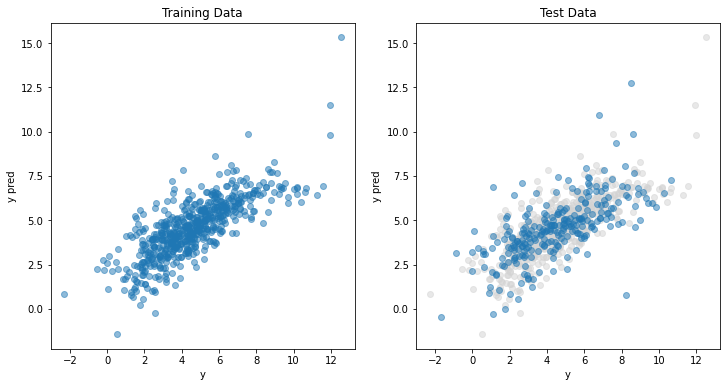

In [14]:
# Plot the y-values verus the predicted y-values for the regular regression for one model
model_alpha = 0

fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.scatter(y_train, CO2_y_pred_train[model_alpha], alpha=0.5, c='lightgrey')
plt.scatter(y_test, CO2_y_pred_test[model_alpha], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Test Data')

plt.subplot(1,2,1)
plt.scatter(y_train, CO2_y_pred_train[model_alpha], alpha=0.5,)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Training Data')
plt.show()


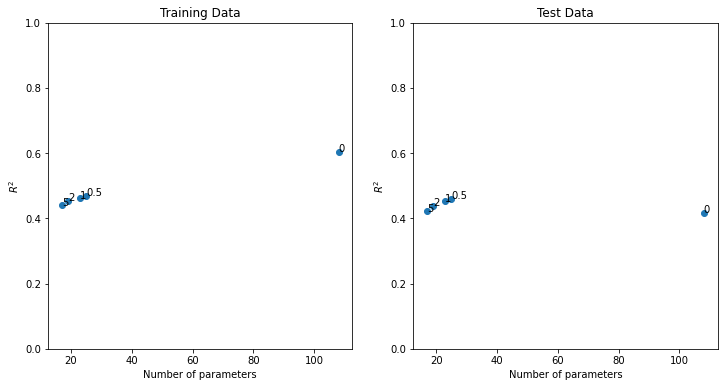

In [15]:
# Plot the R2 values of the models
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(CO2_n_params, CO2_train_r2s)
for i in range(len(CO2_n_params)):
    plt.text(CO2_n_params[i], CO2_train_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Training Data')
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.scatter(CO2_n_params, CO2_test_r2s)
for i in range(len(CO2_n_params)):
    plt.text(CO2_n_params[i], CO2_test_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Test Data')
plt.ylim([0,1])
plt.show()

In [16]:
max(CO2_train_r2s)

0.6038831375238003

In [17]:
max(CO2_test_r2s)

0.4606710630197409

In [18]:
# Create CO2_summary dataframes
CO2_summary = {}
for alpha in alphas:
    CO2_summary[alpha] = pd.DataFrame(columns=['feature', 'coeff'], data=np.array([X.columns[CO2_coeffs[alpha] != 0], CO2_coeffs[alpha][CO2_coeffs[alpha] != 0]]).T)
    CO2_summary[alpha] = CO2_summary[alpha].join(metadata, on='feature')
    CO2_summary[alpha]['coeff_abs'] = CO2_summary[alpha]['coeff'].apply(np.abs)
    CO2_summary[alpha].sort_values(by='coeff_abs', inplace=True, ascending=False)

In [19]:
CO2_summary[0]

,feature,coeff,description,coeff_abs
103,lit_cl_smj-11,-3.798087,NaN,3.798087
69,pnv_cl_smj-13.0,2.507435,NaN,2.507435
50,glc_cl_smj-19,-2.009949,NaN,2.009949
99,lit_cl_smj-4,1.792792,NaN,1.792792
82,fmh_cl_smj-4,-1.647545,NaN,1.647545
...,...,...,...,...
7,GDP_capita,0.00001,"GDP per capita of country, in 2020 US $",0.00001
23,pop_ct_usu,0.000005,"Population count, thousands of people",0.000005
6,CATCH_SKM,0.000001,Area of upstream catchment draining into the r...,0.000001
3,DIS_AVG_LS,-0.000001,"Long-term average discharge, in liters per second",0.000001


In [40]:
CO2_summary[0.5]

,feature,coeff,description,coeff_abs
2,DEPTH_M,-0.019005,"Average depth of reservoir, in meters",0.019005
16,ire_pc_use,-0.014356,"Irrigated area extent, in percent, in total wa...",0.014356
0,DAM_HGT_M,-0.012192,"Height of dam structure, in meters",0.012192
18,swc_pc_uyr,-0.009322,"Annual average of soil water content, in perce...",0.009322
10,inu_pc_umn,0.006119,Annual minimum inundation extent in total wate...,0.006119
13,ari_ix_uav,-0.005616,"Global aridity index, in total watershed upstr...",0.005616
17,pac_pc_use,-0.004098,"Protected area extent, in percent, in total wa...",0.004098
15,pst_pc_use,-0.003118,"Pasture extent, in percent, in total watershed...",0.003118
12,ari_ix_sav,-0.003113,"Global aridity index, in the reach catchment",0.003113
14,for_pc_use,-0.002916,"Forest cover extent, in percent, in total wate...",0.002916


### Change in Fish per GWH

In [21]:
# Filter for dams with fish and power information
fish_data = data[data['fish_per_GWH'].apply(lambda x: not pd.isna(x))]
fish_data = fish_data[features]
fish_data.shape

(977, 141)

In [22]:
# Generate the test and training data 
X = fish_data.drop(columns=['fish_per_GWH'], inplace=False)
y = np.log(np.ceil(np.abs(fish_data['fish_per_GWH']))) * np.sign(fish_data['fish_per_GWH'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [23]:
# Check for features containing NAs
nas = X.isnull().sum()
nas = nas[nas != 0]

In [24]:
# For now, drop columns with NAs. Could potentially use imputation
X.drop(columns=list(nas.index), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# Standardize the data (i.e. set mean to 0 and std to 1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [34]:
# Define alphas
alphas = [1, 0.5, 0.1, 0.05, 0.01, 0]

In [35]:
# Train models and record R2 values and the number of parameters
fish_test_r2s = np.zeros(len(alphas))
fish_train_r2s = np.zeros(len(alphas))
fish_n_params = np.zeros(len(alphas))
fish_coeffs = {}
fish_y_pred_test = {}
fish_y_pred_train = {}

for i in range(len(alphas)):
    alpha = alphas[i]
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(X_train, y_train)    
    fish_test_r2s[i] = reg.score(X_test, y_test)
    fish_train_r2s[i] = reg.score(X_train, y_train)
    fish_y_pred_test[alpha] = reg.predict(X_test)
    fish_y_pred_train[alpha] = reg.predict(X_train)
    fish_coeffs[alpha] = reg.coef_
    fish_n_params[i] = len(fish_coeffs[alpha][fish_coeffs[alpha] != 0])

/var/folders/j2/hzydqpsj70x2_l0y6kvd0v8w0000gn/T/ipykernel_66585/3246559428.py:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(X_train, y_train)
/Users/green/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/green/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+02, tolerance: 1.175e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

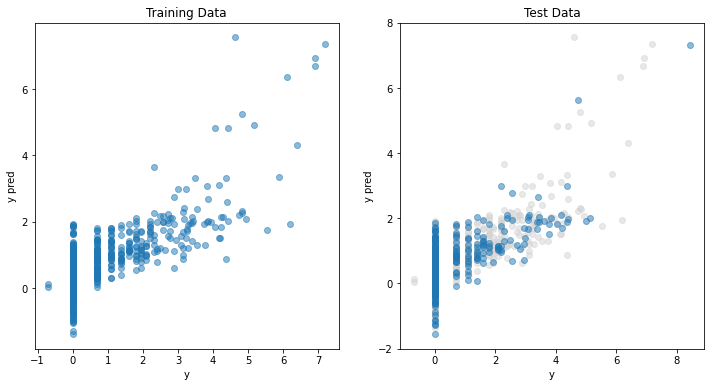

In [36]:
# Plot the y-values verus the predicted y-values for the regular regression
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.scatter(y_train, fish_y_pred_train[alphas[4]], alpha=0.5, c='lightgrey')
plt.scatter(y_test, fish_y_pred_test[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Test Data')

plt.subplot(1,2,1)
plt.scatter(y_train, fish_y_pred_train[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Training Data')
plt.show()


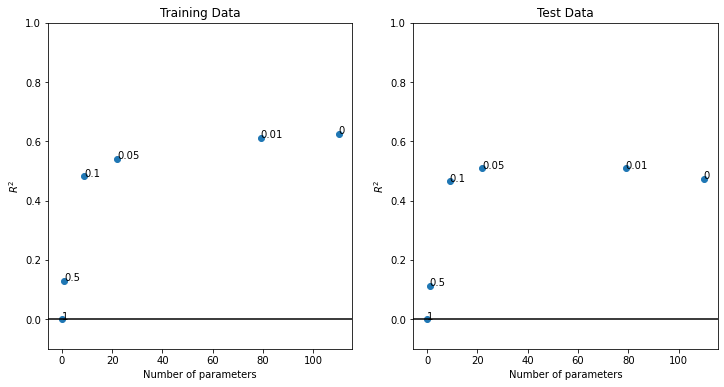

In [37]:
# Plot the R2 values of the models
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(fish_n_params, fish_train_r2s)
for i in range(len(fish_n_params)):
    plt.text(fish_n_params[i], fish_train_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Training Data')
plt.axhline(0, c='k')
plt.ylim([-0.1,1])

plt.subplot(1,2,2)
plt.scatter(fish_n_params, fish_test_r2s)
for i in range(len(fish_n_params)):
    plt.text(fish_n_params[i], fish_test_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Test Data')
plt.axhline(0, c='k')
plt.ylim([-0.1,1])
plt.show()


In [38]:
max(fish_train_r2s)

0.624961458230082

In [39]:
max(fish_test_r2s)

0.5086820597341412

In [32]:
# Create fish_summary dataframes
fish_summary = {}
for alpha in alphas:
    fish_summary[alpha] = pd.DataFrame(columns=['feature', 'coeff'], data=np.array([X.columns[fish_coeffs[alpha] > 0], fish_coeffs[alpha][fish_coeffs[alpha] > 0]]).T)
    fish_summary[alpha] = fish_summary[alpha].join(metadata, on='feature')
    fish_summary[alpha]['coeff_abs'] = fish_summary[alpha]['coeff'].apply(np.abs)
    fish_summary[alpha].sort_values(by='coeff_abs', inplace=True, ascending=False)

In [33]:
fish_summary[0.05]

,feature,coeff,description,coeff_abs
0,DOR_PC,0.597949,Degree of regulation in percent; equivalent to...,0.597949
8,wet_cl_smj-11.0,0.246477,NaN,0.246477
1,ELEV_MASL,0.140299,Elevation of reservoir surface in meters above...,0.140299
9,fmh_cl_smj-8,0.092259,NaN,0.092259
3,ero_kh_uav,0.078677,"Soil erosion, in kg per hectare per year, in t...",0.078677
5,clz_cl_smj-15,0.046936,NaN,0.046936
10,lit_cl_smj-3,0.046304,NaN,0.046304
2,inu_pc_umn,0.028771,Annual minimum inundation extent in total wate...,0.028771
7,glc_cl_smj-1,0.014467,NaN,0.014467
6,clz_cl_smj-6,0.010272,NaN,0.010272
